In [1]:
#basic imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
sns.set()
import os
import sys
import tomotopy as tp
import os
import re
import pyLDAvis 
import seaborn as sns
import urllib
from urllib.request import urlretrieve
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pickle

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))
#print(os.walk('/kaggle/input'))

In [2]:
def normalize_scores(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    normalized_scores = (scores - min_score) / (max_score - min_score)
    return normalized_scores

def calculate_relevance(topic_term_dists, term_freqs, laming=True):
    if laming:
        lambdas = [0.,0.25, 0.5, 0.75]
        results = []
        """Calculate relevance for each term in each topic."""
        for lams in lambdas: 
            topic_term_dists = np.array(topic_term_dists)
            term_freqs = np.array(term_freqs)
            term_freqs = term_freqs / term_freqs.sum()  # Normalize term frequencies
            relevance = lams * np.log(topic_term_dists) + (1 - lams) * np.log(topic_term_dists / term_freqs)
            normalized_relevance = normalize_scores(relevance)
            results.append(normalized_relevance)
        return results 
    else: 
        results = []
        """Calculate relevance for each term in each topic."""
        lams = 0.5
        topic_term_dists = np.array(topic_term_dists)
        term_freqs = np.array(term_freqs)
        term_freqs = term_freqs / term_freqs.sum()  # Normalize term frequencies
        relevance = lams * np.log(topic_term_dists) + (1 - lams) * np.log(topic_term_dists / term_freqs)
        normalized_relevance = normalize_scores(relevance)
        results.append(normalized_relevance)
        return normalized_relevance
    

'''def calculate_saliency(topic_term_dists, term_freqs):
    """Calculate saliency for each term."""
    p_w = term_freqs / term_freqs.sum()
    saliency = (topic_term_dists * np.log(topic_term_dists / p_w)).sum(axis=0)
    return saliency'''
def calculate_saliency(topic_term_dists, term_freqs):
    term_freqs = np.array(term_freqs)
    term_freqs = term_freqs / term_freqs.sum()  # Normalize term frequencies

    num_topics, num_terms = topic_term_dists.shape
    saliency = np.zeros_like(topic_term_dists)
    for k in range(num_topics):  # For each topic
        for w in range(num_terms):  # For each word in the vocabulary
            p_word_given_topic = topic_term_dists[k, w]
            p_word_in_corpus = term_freqs[w]
            saliency[k, w] += p_word_given_topic * np.log(p_word_given_topic / p_word_in_corpus)
    
    # for term_idx in range(num_terms):
    #     # p(t | w) is topic_term_dists[:, term_idx]
    #     p_t_given_w = topic_term_dists[:, term_idx]
        
    #     # p(t) is the overall topic distribution
    #     p_t = np.mean(topic_term_dists, axis=1)
        
    #     # Calculate saliency for the term
    #     saliency_term = np.sum(p_t_given_w * np.log(p_t_given_w / p_t)) * term_freqs[term_idx]
    #     saliency[term_idx] = saliency_term
    normalized_saliency = normalize_scores(saliency)
    return normalized_saliency


In [43]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    stop_words = set(["a", "an", "the", "and", "or", "but", "if", "on", "in", "to", "is", "of", "for", 'you', 'that', 'are', 'with', 'features', 'performance', 'learning', 'this', 'from', 'which', 'each'])
    words = [word for word in text.split() if len(word) > 2 and word not in stop_words]
    return words

In [10]:

def lda_example(file_paths, timestamps):
    mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=3, rm_top=15, k=13   )#,#tw=tp.TermWeight.IDF)#alpha=0.1, eta=0.01)
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            text = f.read()
            processed_text = preprocess_text(text)
            mdl.add_doc(processed_text)
            doc_timestamps.append(timestamp)
            # for line in f:
            #     words = preprocess_text(line.strip())
            #     if words:
            #         texts.append(words)
            #         mdl.add_doc(words)
            #         doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    mdl.burn_in = 500
    mdl.train(0)
    print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    print('Removed top words:', mdl.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    mdl.train(100, show_progress=True)
    mdl.summary()

    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)
    
    d = {'pdf':[],'authors': [], 'titles': [], 'number': [], 'available':[]}
    LDA_all = pd.DataFrame({
            'Probability Words': [],
            'Relevance Words': [],
            'Saliency Words': [],
            'Probability Scores': [],
            'Relevance Scores': [],
            'Saliency Scores': []
        })
    
    topics=[]
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        print(f'Topic #{k}')
        words_probs = mdl.get_topic_words(k)
        top_prob_words = [(word, prob) for word, prob in words_probs[:3]]

        relevance_scores = relevance[k]
        relevance_indices = np.argsort(relevance_scores)[::-1]
        saliency_scores = saliency[k]
        saliency_indices = np.argsort(saliency_scores)[::-1]

        top_relevance_words = [(vocab[idx], relevance_scores[idx]) for idx in relevance_indices[:3]]
        top_saliency_words = [(vocab[idx], saliency_scores[idx]) for idx in saliency_indices[:3]]

        prob_words = [word for word, _ in top_prob_words]
        prob_values = [score for _, score in top_prob_words]
        relevance_words = [word for word, _ in top_relevance_words]
        relevance_values = [score for _, score in top_relevance_words]
        saliency_words = [word for word, _ in top_saliency_words]
        saliency_values = [score for _, score in top_saliency_words]
        
        
        

        # Create DataFrame with words and scores for all three metrics
        combined_df = pd.DataFrame({
            'Probability Words': prob_words,
            'Relevance Words': relevance_words,
            'Saliency Words': saliency_words,
            'Probability Scores': prob_values,
            'Relevance Scores': relevance_values,
            'Saliency Scores': saliency_values
        })
        LDA_all = pd.concat([LDA_all, combined_df], ignore_index=True)
        combined_df.to_csv(f'results{k}.csv')
        print(combined_df.to_string(index=False))
    prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency,
        start_index=0, 
        sort_topics=False 
    )
    pyLDAvis.save_html(prepared_data, 'ldavis.html')
    # Aggregate topic distributions by time periods
    df = pd.DataFrame(doc_topic_dists, columns=[f'Topic_{i}' for i in range(mdl.k)])
    df['Timestamp'] = doc_timestamps
    
    # Calculate the average topic distribution for each time period
    topic_over_time = df.groupby('Timestamp').mean().reset_index()
    
    # Smooth out the frequency lines using a rolling average
    topic_over_time_smooth = topic_over_time.set_index('Timestamp').rolling(window=6, min_periods=1).mean().reset_index()
    
    # Plot the topic frequencies over time
    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns[1:]:
        plt.plot(topic_over_time_smooth['Timestamp'], topic_over_time_smooth[topic], label=topic)
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 10))  # Adjust figure size for better visibility
    df_melted = topic_over_time_smooth.melt(id_vars='Timestamp', var_name='Topic', value_name='Proportion')
    g = sns.FacetGrid(df_melted, col='Topic', col_wrap=4, sharey=False, height=3)
    g.map(sns.lineplot, 'Timestamp', 'Proportion')
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels('Time Period', 'Average Topic Proportion')
    g.fig.suptitle('Topic Frequencies Over Time (Smoothed)', y=1.02)  # Title with better positioning
    g.add_legend()
    plt.tight_layout()
    plt.show()

In [30]:

def lda_quick(file_paths, timestamps, num):
    mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=3, rm_top=15, k=num)#,#tw=tp.TermWeight.IDF)#alpha=0.1, eta=0.01)
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            text = f.read()
            processed_text = preprocess_text(text)
            texts.append(processed_text)
            mdl.add_doc(processed_text)
            doc_timestamps.append(timestamp)
            # for line in f:
            #     words = preprocess_text(line.strip())
            #     if words:
            #         texts.append(words)
            # for line in f:
            #     words = preprocess_text(line.strip())
            #     if words:
            #         texts.append(words)
            #         mdl.add_doc(words)
            #         doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    mdl.burn_in = 500
    mdl.train(0)
    #print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    mdl.removed_top_words
    #print('Removed top words:', mdl.removed_top_words)
    #print('Training...', file=sys.stderr, flush=True)
    mdl.train(100, show_progress=True)
    #mdl.summary()
    
    topics=[]
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        
    return topics, texts, dictionary 

In [12]:

def get_all_files_in_directory(directory):
    file_paths = []
    timestamps = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                file_paths.append(os.path.join(root, file))
                timestamp = os.path.basename(root)
                timestamps.append(timestamp)
    return file_paths, timestamps



In [7]:
# Path to the main directory containing subdirectories with text files
main_directory_path = './PSB_Papers/main_body'

print('Running LDA')

# Get all file paths in the main directory and its subdirectories
file_paths, timestamps = get_all_files_in_directory(main_directory_path)

Running LDA


In [8]:
titles = []
texts = []
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        processed_text = preprocess_text(text)
        texts.append(processed_text)
        titles.append(file_path[23:])
print(titles)

['1996\\10_main_body.txt', '1996\\11_main_body.txt', '1996\\12_main_body.txt', '1996\\13_main_body.txt', '1996\\14_main_body.txt', '1996\\15_main_body.txt', '1996\\16_main_body.txt', '1996\\17_main_body.txt', '1996\\18_main_body.txt', '1996\\19_main_body.txt', '1996\\21_main_body.txt', '1996\\22_main_body.txt', '1996\\23_main_body.txt', '1996\\24_main_body.txt', '1996\\25_main_body.txt', '1996\\26_main_body.txt', '1996\\27_main_body.txt', '1996\\28_main_body.txt', '1996\\30_main_body.txt', '1996\\31_main_body.txt', '1996\\35_main_body.txt', '1996\\37_main_body.txt', '1996\\39_main_body.txt', '1996\\40_main_body.txt', '1996\\41_main_body.txt', '1996\\42_main_body.txt', '1996\\43_main_body.txt', '1996\\44_main_body.txt', '1996\\45_main_body.txt', '1996\\47_main_body.txt', '1996\\50_main_body.txt', '1996\\53_main_body.txt', '1996\\54_main_body.txt', '1997\\10_main_body.txt', '1997\\11_main_body.txt', '1997\\12_main_body.txt', '1997\\13_main_body.txt', '1997\\14_main_body.txt', '1997\\15_m

In [57]:
# Get topic assignments for each document
doc_topic_dists = np.array([doc.get_topic_dist() for doc in model.docs])
df = {"document":[], "topic":[], "distr":[]}

# Get the most likely topic assignment for each document
topic_assignments = np.argmax(doc_topic_dists, axis=1)
print(len(topic_assignments))
print(len(titles))

for i, topic in enumerate(topic_assignments):
    df['document'].append(titles[i])
    df["topic"].append(topic)
    df["distr"].append(doc_topic_dists[i])
    print(f"Document {titles[i]} is assigned to topic {topic} with {doc_topic_dists[i]} distribution")

fin_df = pd.DataFrame(data=df)
fin_df.to_csv('LDA_topics_documents.csv') 

1174
1174
Document 1996\10_main_body.txt is assigned to topic 0 with [5.2092910e-01 3.2582842e-02 3.0846679e-01 7.9276993e-05 7.9276993e-05
 3.7339464e-02 7.9276993e-05 7.9276993e-05 3.8925003e-02 7.9276993e-05
 1.1178056e-02 7.9276993e-05 5.0023779e-02 7.9276993e-05] distribution
Document 1996\11_main_body.txt is assigned to topic 0 with [0.35456887 0.0006435  0.12934364 0.0006435  0.0006435  0.2001287
 0.0006435  0.0006435  0.20656371 0.0006435  0.02638353 0.0006435
 0.07142857 0.00707851] distribution
Document 1996\12_main_body.txt is assigned to topic 2 with [1.6253847e-01 2.6070837e-02 5.2382267e-01 3.9441511e-05 3.7114460e-02
 8.4444277e-02 3.9441511e-05 3.9441511e-05 4.0664196e-02 5.2102238e-02
 1.0294234e-02 3.1947624e-03 1.9760195e-02 3.9875366e-02] distribution
Document 1996\13_main_body.txt is assigned to topic 8 with [9.5343450e-03 1.9284661e-01 7.2745472e-02 6.3737887e-03 5.2675940e-05
 6.2210280e-02 4.7935103e-03 3.3238515e-02 5.3102612e-01 5.2675940e-05
 5.2675940e-05 5.

In [32]:
scores = []
for i in range(3, 20):
    topics, texts, dictionary  = lda_quick(file_paths, timestamps, i)
    print(topics)
    print(dictionary)
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f'Coherence Score for {i}: {coherence_score}')
    scores.append(coherence_score)

Iteration: 100%|██████████| 100/100 [00:01<00:00, 69.20it/s, LLPW: -8.695587]


[['proteins', 'interactions', 'binding', 'structure', 'snp', 'cell', 'interaction', 'molecular', 'pathway', 'residues'], ['sequences', 'algorithm', 'information', 'time', 'tree', 'use', 'given', 'terms', 'size', 'from'], ['disease', 'drug', 'cancer', 'samples', 'models', 'features', 'data', 'patients', 'performance', 'snps']]
Dictionary<30725 unique tokens: ['able', 'account', 'across', 'acting', 'actions']...>
Coherence Score for 3: 0.4440253056778596


Iteration: 100%|██████████| 100/100 [00:02<00:00, 45.33it/s, LLPW: -8.725105]


[['cell', 'drug', 'features', 'cancer', 'performance', 'data', 'class', 'terms', 'samples', 'learning'], ['snp', 'snps', 'disease', 'genetic', 'clinical', 'variants', 'population', 'association', 'studies', 'type'], ['proteins', 'structure', 'binding', 'sequences', 'site', 'structures', 'sites', 'residues', 'regions', 'amino'], ['time', 'algorithm', 'tree', 'size', 'from', 'this', 'given', 'probability', 'use', 'problem']]
Dictionary<30725 unique tokens: ['able', 'account', 'across', 'acting', 'actions']...>
Coherence Score for 4: 0.5849619457763982


Iteration: 100%|██████████| 100/100 [00:01<00:00, 51.19it/s, LLPW: -8.735627]


[['features', 'performance', 'models', 'data', 'class', 'training', 'prediction', 'feature', 'learning', 'values'], ['proteins', 'structure', 'binding', 'site', 'sites', 'sequences', 'structures', 'residues', 'amino', 'rna'], ['drug', 'information', 'terms', 'system', 'database', 'knowledge', 'text', 'user', 'drugs', 'harm'], ['tree', 'algorithm', 'time', 'networks', 'from', 'this', 'graph', 'sub', 'size', 'sequences'], ['disease', 'cancer', 'patients', 'snp', 'snps', 'clinical', 'cell', 'samples', 'genetic', 'associated']]
Dictionary<30725 unique tokens: ['able', 'account', 'across', 'acting', 'actions']...>
Coherence Score for 5: 0.5739645444999948


Iteration: 100%|██████████| 100/100 [00:02<00:00, 41.69it/s, LLPW: -8.740629]


[['system', 'information', 'terms', 'use', 'text', 'example', 'systems', 'user', 'knowledge', 'term'], ['proteins', 'structure', 'binding', 'residues', 'structures', 'site', 'amino', 'sites', 'structural', 'energy'], ['snp', 'snps', 'disease', 'genetic', 'variants', 'population', 'clinical', 'association', 'studies', 'individuals'], ['data', 'values', 'time', 'algorithm', 'models', 'matrix', 'performance', 'value', 'function', 'size'], ['sequences', 'tree', 'from', 'this', 'alignment', 'can', 'species', 'length', 'which', 'genome'], ['cell', 'drug', 'cancer', 'disease', 'pathway', 'interactions', 'pathways', 'specific', 'samples', 'features']]
Dictionary<30725 unique tokens: ['able', 'account', 'across', 'acting', 'actions']...>
Coherence Score for 6: 0.5782905994944184


Iteration: 100%|██████████| 100/100 [00:02<00:00, 41.99it/s, LLPW: -8.749315]


[['features', 'performance', 'data', 'learning', 'training', 'models', 'patients', 'feature', 'class', 'patient'], ['drug', 'information', 'terms', 'system', 'database', 'text', 'harm', 'user', 'example', 'ontology'], ['proteins', 'structure', 'binding', 'structures', 'residues', 'amino', 'site', 'structural', 'energy', 'sites'], ['networks', 'graph', 'interactions', 'cluster', 'matrix', 'pathway', 'sub', 'clustering', 'clusters', 'nodes'], ['disease', 'snp', 'snps', 'genetic', 'population', 'association', 'variants', 'individuals', 'plo', 'studies'], ['sequences', 'tree', 'algorithm', 'time', 'from', 'this', 'size', 'can', 'length', 'given'], ['cell', 'cancer', 'cells', 'mutations', 'dna', 'mutation', 'tumor', 'human', 'rna', 'type']]
Dictionary<30725 unique tokens: ['able', 'account', 'across', 'acting', 'actions']...>
Coherence Score for 7: 0.6165300692063467


Iteration: 100%|██████████| 100/100 [00:01<00:00, 56.29it/s, LLPW: -8.767412]


[['terms', 'information', 'database', 'text', 'system', 'knowledge', 'ontology', 'harm', 'example', 'term'], ['cancer', 'class', 'data', 'samples', 'features', 'performance', 'training', 'cluster', 'values', 'clustering'], ['structure', 'proteins', 'sequences', 'binding', 'site', 'alignment', 'sites', 'residues', 'structures', 'amino'], ['cell', 'drug', 'networks', 'interactions', 'pathway', 'pathways', 'interaction', 'proteins', 'cells', 'biological'], ['algorithm', 'tree', 'time', 'from', 'this', 'size', 'problem', 'given', 'probability', 'can'], ['patients', 'clinical', 'patient', 'disease', 'models', 'health', 'time', 'performance', 'features', 'learning'], ['system', 'time', 'dna', 'genome', 'systems', 'reaction', 'reactions', 'meta', 'species', 'reads'], ['snp', 'snps', 'disease', 'genetic', 'variants', 'association', 'population', 'plo', 'type', 'individuals']]
Dictionary<30725 unique tokens: ['able', 'account', 'across', 'acting', 'actions']...>
Coherence Score for 8: 0.5752746

Iteration: 100%|██████████| 100/100 [00:01<00:00, 56.92it/s, LLPW: -8.766692]


[['proteins', 'structure', 'binding', 'sequences', 'sites', 'alignment', 'site', 'residues', 'structures', 'amino'], ['system', 'molecular', 'user', 'information', 'tools', 'use', 'new', 'available', 'systems', 'bio'], ['disease', 'clinical', 'patients', 'patient', 'health', 'risk', 'diseases', 'age', 'studies', 'associated'], ['features', 'performance', 'models', 'data', 'class', 'training', 'feature', 'learning', 'prediction', 'test'], ['tree', 'algorithm', 'species', 'distance', 'probability', 'sequences', 'matrix', 'genome', 'given', 'different'], ['time', 'from', 'this', 'can', 'size', 'state', 'model', 'each', 'data', 'which'], ['cell', 'cancer', 'drug', 'pathway', 'networks', 'interactions', 'pathways', 'cells', 'cluster', 'biological'], ['terms', 'text', 'information', 'harm', 'database', 'term', 'ontology', 'query', 'knowledge', 'annotation'], ['snp', 'snps', 'genetic', 'variants', 'type', 'plo', 'population', 'association', 'genotype', 'was']]
Dictionary<30725 unique tokens: 

Iteration: 100%|██████████| 100/100 [00:02<00:00, 47.11it/s, LLPW: -8.772872]


[['terms', 'information', 'system', 'text', 'user', 'database', 'harm', 'use', 'ontology', 'term'], ['disease', 'snp', 'snps', 'clinical', 'genetic', 'variants', 'association', 'patients', 'associated', 'diseases'], ['features', 'performance', 'learning', 'training', 'prediction', 'class', 'feature', 'drug', 'models', 'data'], ['structure', 'proteins', 'binding', 'residues', 'structures', 'sites', 'amino', 'site', 'structural', 'energy'], ['time', 'state', 'system', 'states', 'reactions', 'reaction', 'activity', 'level', 'compounds', 'molecular'], ['sequences', 'rna', 'class', 'dna', 'alignment', 'motif', 'score', 'human', 'regions', 'genome'], ['networks', 'interactions', 'pathway', 'graph', 'pathways', 'interaction', 'cluster', 'biological', 'clusters', 'clustering'], ['values', 'different', 'models', 'distribution', 'value', 'rate', 'test', 'time', 'first', 'error'], ['cell', 'samples', 'cells', 'type', 'types', 'plo', 'tumor', 'tissue', 'marker', 'specific'], ['tree', 'algorithm', 

Iteration: 100%|██████████| 100/100 [00:02<00:00, 43.65it/s, LLPW: -8.753181]


[['snp', 'snps', 'disease', 'genetic', 'variants', 'association', 'population', 'individuals', 'associated', 'phenotype'], ['features', 'patients', 'models', 'patient', 'learning', 'performance', 'clinical', 'data', 'training', 'feature'], ['time', 'state', 'models', 'system', 'rate', 'parameters', 'values', 'simulation', 'states', 'fig'], ['proteins', 'structure', 'binding', 'residues', 'structures', 'amino', 'structural', 'energy', 'domain', 'residue'], ['tree', 'plo', 'species', 'type', 'mutation', 'trees', 'distance', 'reads', 'genome', 'algorithm'], ['information', 'terms', 'system', 'text', 'database', 'user', 'knowledge', 'term', 'ontology', 'use'], ['this', 'from', 'can', 'each', 'which', 'model', 'our', 'not', 'all', 'size'], ['drug', 'interactions', 'disease', 'interaction', 'drugs', 'harm', 'proteins', 'pairs', 'similarity', 'diseases'], ['class', 'score', 'values', 'algorithm', 'function', 'data', 'matrix', 'performance', 'value', 'different'], ['cell', 'cancer', 'pathway',

Iteration: 100%|██████████| 100/100 [00:01<00:00, 51.20it/s, LLPW: -8.759970]


[['cell', 'state', 'system', 'biological', 'function', 'models', 'dna', 'cells', 'states', 'level'], ['features', 'performance', 'models', 'learning', 'training', 'feature', 'class', 'data', 'prediction', 'classification'], ['drug', 'drugs', 'target', 'cell', 'harm', 'pathway', 'pathways', 'chemical', 'response', 'targets'], ['disease', 'patients', 'clinical', 'patient', 'health', 'risk', 'diseases', 'age', 'studies', 'associated'], ['algorithm', 'tree', 'from', 'this', 'size', 'data', 'can', 'probability', 'model', 'each'], ['snp', 'snps', 'variants', 'genetic', 'plo', 'population', 'association', 'type', 'genotype', 'was'], ['binding', 'structure', 'residues', 'sites', 'structures', 'proteins', 'site', 'energy', 'amino', 'residue'], ['time', 'rate', 'parameters', 'use', 'simulation', 'different', 'first', 'large', 'new', 'real'], ['cancer', 'cell', 'samples', 'cluster', 'clusters', 'clustering', 'tumor', 'mutations', 'cells', 'specific'], ['sequences', 'proteins', 'alignment', 'score

Iteration: 100%|██████████| 100/100 [00:02<00:00, 49.08it/s, LLPW: -8.771296]


[['rna', 'base', 'dna', 'test', 'patterns', 'see', 'pattern', 'topo', 'long', 'rnas'], ['system', 'user', 'information', 'use', 'molecular', 'systems', 'tools', 'new', 'database', 'work'], ['sequences', 'this', 'from', 'tree', 'can', 'each', 'which', 'model', 'alignment', 'data'], ['networks', 'graph', 'interactions', 'pathway', 'interaction', 'pathways', 'nodes', 'biological', 'edges', 'node'], ['disease', 'clinical', 'patients', 'diseases', 'risk', 'genetic', 'health', 'associated', 'association', 'studies'], ['snp', 'snps', 'genome', 'type', 'plo', 'variants', 'mutation', 'mutations', 'population', 'samples'], ['algorithm', 'time', 'problem', 'matrix', 'size', 'first', 'optimal', 'given', 'step', 'algorithms'], ['structure', 'binding', 'residues', 'structures', 'proteins', 'amino', 'energy', 'site', 'sites', 'residue'], ['features', 'performance', 'data', 'learning', 'training', 'feature', 'models', 'samples', 'class', 'prediction'], ['values', 'distribution', 'rate', 'models', 'tim

Iteration: 100%|██████████| 100/100 [00:02<00:00, 48.31it/s, LLPW: -8.746529]


[['sequences', 'sites', 'site', 'alignment', 'dna', 'motif', 'regions', 'rna', 'binding', 'domain'], ['molecular', 'state', 'energy', 'surface', 'molecules', 'conformation', 'simulation', 'free', 'site', 'potential'], ['values', 'probability', 'distribution', 'matrix', 'algorithm', 'error', 'parameters', 'rate', 'value', 'models'], ['networks', 'graph', 'cluster', 'interactions', 'pathway', 'clustering', 'nodes', 'clusters', 'pathways', 'interaction'], ['cancer', 'samples', 'tumor', 'mutations', 'mutation', 'survival', 'patients', 'reads', 'genomic', 'sequencing'], ['proteins', 'structure', 'residues', 'structures', 'binding', 'structural', 'amino', 'residue', 'function', 'similarity'], ['snp', 'snps', 'disease', 'genetic', 'association', 'variants', 'plo', 'phenotype', 'genotype', 'was'], ['features', 'performance', 'learning', 'training', 'models', 'class', 'feature', 'prediction', 'data', 'classification'], ['tree', 'from', 'this', 'algorithm', 'can', 'model', 'size', 'each', 'which

Iteration: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s, LLPW: -8.743687]


[['from', 'this', 'can', 'data', 'model', 'each', 'which', 'not', 'our', 'all'], ['terms', 'text', 'ontology', 'term', 'information', 'knowledge', 'system', 'relations', 'concepts', 'relationships'], ['meta', 'human', 'flow', 'work', 'brain', 'group', 'sequencing', 'within', 'multiple', 'community'], ['interactions', 'proteins', 'networks', 'graph', 'interaction', 'nodes', 'functional', 'similarity', 'edges', 'node'], ['mutations', 'mutation', 'somatic', 'peptide', 'peptides', 'mass', 'samples', 'spectra', 'spectrum', 'clone'], ['cluster', 'clustering', 'clusters', 'matrix', 'cell', 'correlation', 'data', 'fig', 'image', 'values'], ['state', 'system', 'time', 'cell', 'activity', 'reactions', 'reaction', 'chemical', 'cells', 'molecules'], ['algorithm', 'tree', 'time', 'probability', 'distance', 'size', 'given', 'optimal', 'parameters', 'matrix'], ['structure', 'residues', 'structures', 'binding', 'proteins', 'energy', 'residue', 'amino', 'surface', 'structural'], ['sequences', 'alignmen

Iteration: 100%|██████████| 100/100 [00:02<00:00, 46.09it/s, LLPW: -8.757604]


[['pathway', 'pathways', 'cell', 'system', 'cells', 'regulatory', 'drug', 'reactions', 'reaction', 'module'], ['mutations', 'mutation', 'cancer', 'somatic', 'tumor', 'gfr', 'topo', 'mutated', 'signatures', 'all'], ['structure', 'residues', 'structures', 'energy', 'amino', 'residue', 'structural', 'surface', 'conformation', 'secondary'], ['networks', 'graph', 'time', 'nodes', 'node', 'matrix', 'edges', 'sub', 'state', 'algorithm'], ['sequences', 'alignment', 'score', 'algorithm', 'length', 'motif', 'rna', 'dna', 'pairs', 'genome'], ['terms', 'drug', 'text', 'harm', 'knowledge', 'information', 'ontology', 'term', 'relationships', 'relations'], ['features', 'performance', 'learning', 'models', 'feature', 'training', 'prediction', 'patient', 'drug', 'patients'], ['cell', 'cancer', 'samples', 'cluster', 'clustering', 'clusters', 'cells', 'specific', 'types', 'tumor'], ['disease', 'snp', 'snps', 'genetic', 'association', 'variants', 'individuals', 'clinical', 'associated', 'studies'], ['tree

Iteration: 100%|██████████| 100/100 [00:02<00:00, 42.20it/s, LLPW: -8.742480]


[['cell', 'time', 'state', 'cells', 'system', 'states', 'models', 'regulatory', 'activity', 'level'], ['sites', 'sequences', 'site', 'dna', 'rna', 'motif', 'binding', 'regions', 'motifs', 'genome'], ['image', 'imaging', 'peak', 'spatial', 'images', 'mass', 'brain', 'regions', 'peaks', 'segmentation'], ['proteins', 'alignment', 'amino', 'residues', 'structure', 'structural', 'domain', 'sequences', 'alignments', 'function'], ['disease', 'snp', 'snps', 'genetic', 'population', 'plo', 'type', 'genotype', 'individuals', 'phenotype'], ['cancer', 'cell', 'samples', 'tumor', 'mutations', 'types', 'mutation', 'reads', 'seq', 'cells'], ['networks', 'interactions', 'graph', 'pathway', 'cluster', 'pathways', 'clusters', 'clustering', 'interaction', 'nodes'], ['user', 'information', 'use', 'database', 'tools', 'bio', 'new', 'available', 'work', 'system'], ['this', 'from', 'can', 'each', 'which', 'our', 'data', 'size', 'all', 'model'], ['patients', 'patient', 'clinical', 'features', 'models', 'embed

Iteration: 100%|██████████| 100/100 [00:02<00:00, 34.86it/s, LLPW: -8.716301]


[['energy', 'molecular', 'surface', 'peptide', 'conformation', 'potential', 'points', 'free', 'fig', 'point'], ['cancer', 'cell', 'samples', 'tumor', 'cells', 'types', 'mutations', 'patients', 'specific', 'rna'], ['sequences', 'motif', 'class', 'dna', 'motifs', 'patterns', 'database', 'table', 'site', 'classes'], ['features', 'performance', 'learning', 'training', 'feature', 'models', 'prediction', 'class', 'classification', 'data'], ['cluster', 'clusters', 'clustering', 'matrix', 'data', 'distance', 'micro', 'see', 'vector', 'cell'], ['clinical', 'patients', 'disease', 'patient', 'health', 'medical', 'age', 'risk', 'diseases', 'treatment'], ['networks', 'interactions', 'graph', 'pathway', 'pathways', 'interaction', 'nodes', 'disease', 'node', 'sub'], ['exposure', 'human', 'non', 'use', 'time', 'object', 'questions', 'studies', 'classes', 'event'], ['genetic', 'association', 'variants', 'disease', 'was', 'phenotype', 'associations', 'phenotypes', 'associated', 'snps'], ['state', 'cell'

Iteration: 100%|██████████| 100/100 [00:02<00:00, 38.69it/s, LLPW: -8.767515]


[['drug', 'pathway', 'pathways', 'drugs', 'biological', 'harm', 'target', 'disease', 'regulatory', 'known'], ['structure', 'structures', 'energy', 'chain', 'points', 'point', 'conformation', 'surface', 'state', 'residues'], ['binding', 'system', 'ligand', 'time', 'interactions', 'state', 'reaction', 'proteins', 'function', 'chemical'], ['embedding', 'patient', 'time', 'layer', 'deep', 'clinical', 'patients', 'learning', 'health', 'information'], ['terms', 'text', 'information', 'system', 'ontology', 'term', 'knowledge', 'relations', 'example', 'concepts'], ['sequences', 'alignment', 'sites', 'site', 'score', 'binding', 'motif', 'length', 'dna', 'structure'], ['snp', 'snps', 'variants', 'genetic', 'plo', 'population', 'type', 'association', 'genotype', 'allele'], ['user', 'tools', 'use', 'bio', 'new', 'available', 'work', 'information', 'software', 'tool'], ['proteins', 'mutations', 'mutation', 'residues', 'human', 'domain', 'reads', 'structural', 'domains', 'regions'], ['tree', 'time',

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


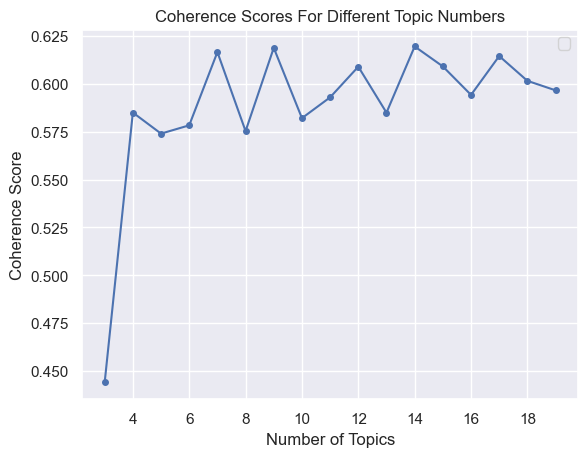

In [36]:
plt.plot(range(3,20), scores, marker='o', linestyle='-', markersize=4)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores For Different Topic Numbers')
plt.legend()
plt.show()

Training...


Num docs: 349035 , Vocab size: 20287 , Num words: 2151360
Removed top words: ['gene', 'set', 'using', 'genes', 'number', 'used', 'two', 'one', 'protein', 'based', 'also', 'methods', 'sequence', 'network', 'expression']


Iteration: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s, LLPW: -8.841586]


<Basic Info>
| LDAModel (current version: 0.12.7)
| 349035 docs, 2151360 words
| Total Vocabs: 30729, Used Vocabs: 20287
| Entropy of words: 8.35542
| Entropy of term-weighted words: 8.35542
| Removed Vocabs: gene set using genes number used two one protein based also methods sequence network expression
|
<Training Info>
| Iterations: 100, Burn-in steps: 500
| Optimization Interval: 10
| Log-likelihood per word: -8.82890
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 15 (the number of top words to be removed)
| k: 14 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 706886344 (random seed)
| trained in version 0.1

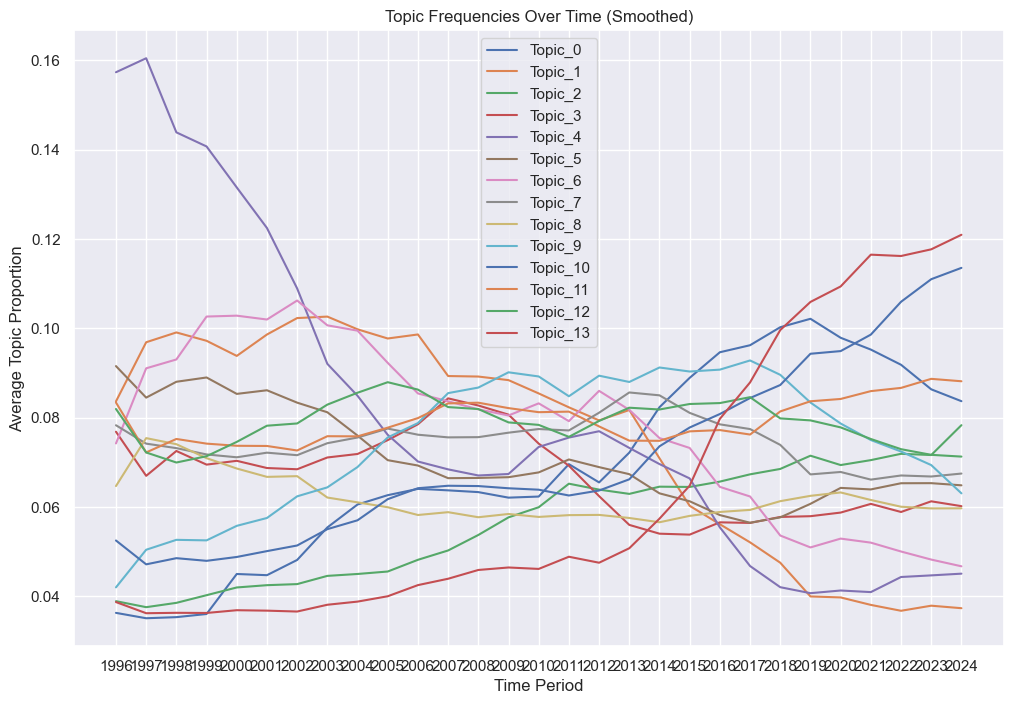

<Figure size 1400x1000 with 0 Axes>

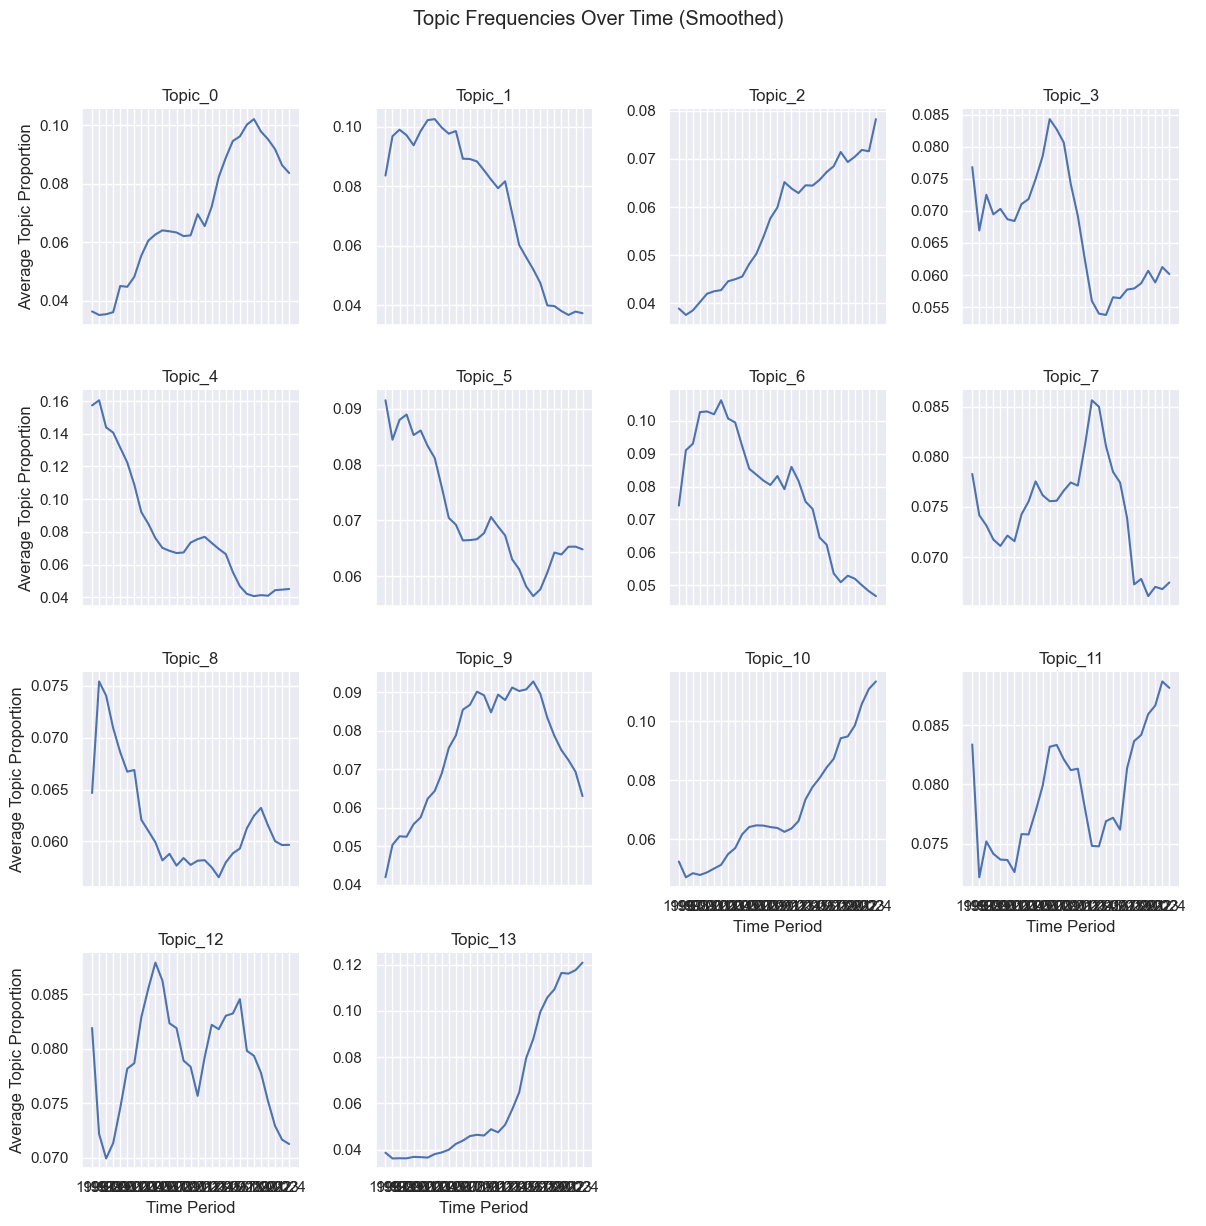

In [19]:
# Run the LDA model on all files
lda_example(file_paths, timestamps)

In [44]:
def lda_make_csv(file_paths, timestamps, word_num=5):
    mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=3, rm_top=15, k=14   )#,#tw=tp.TermWeight.IDF)#alpha=0.1, eta=0.01)
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            text = f.read()
            processed_text = preprocess_text(text)
            mdl.add_doc(processed_text)
            doc_timestamps.append(timestamp)
            # for line in f:
            #     words = preprocess_text(line.strip())
            #     if words:
            #         texts.append(words)
            #         mdl.add_doc(words)
            #         doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    mdl.burn_in = 500
    mdl.train(0)
    print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    print('Removed top words:', mdl.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    mdl.train(100, show_progress=True)
    mdl.summary()

    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency, laming=False)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)
    
    d = {'pdf':[],'authors': [], 'titles': [], 'number': [], 'available':[]}
    LDA_all = pd.DataFrame({
            'Probability Words': [],
            'Relevance Words': [],
            'Saliency Words': [],
            'Probability Scores': [],
            'Relevance Scores': [],
            'Saliency Scores': []
        })
    
    topics=[]
    fin_df = {'Topic':[], 'Type':[], 'Words':[], 'Scores':[]}
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        print(f'Topic #{k}')
        words_probs = mdl.get_topic_words(k)
        top_prob_words = [(word, prob) for word, prob in words_probs[:word_num]]

        relevance_scores = relevance[k]
        relevance_indices = np.argsort(relevance_scores)[::-1]
        saliency_scores = saliency[k]
        saliency_indices = np.argsort(saliency_scores)[::-1]

        top_relevance_words = [(vocab[idx], relevance_scores[idx]) for idx in relevance_indices[:word_num]]
        top_saliency_words = [(vocab[idx], saliency_scores[idx]) for idx in saliency_indices[:word_num]]

        prob_words = [word for word, _ in top_prob_words]
        prob_values = [str(score)[:4] for _, score in top_prob_words]
        relevance_words = [word for word, _ in top_relevance_words]
        relevance_values = [str(score)[:4] for _, score in top_relevance_words]
        saliency_words = [word for word, _ in top_saliency_words]
        saliency_values = [str(score)[:4] for _, score in top_saliency_words]
        
        # Create DataFrame with words and scores for all three metrics
        combined_df = pd.DataFrame({
            'Probability Words': prob_words,
            'Relevance Words': relevance_words,
            'Saliency Words': saliency_words,
            'Probability Scores': prob_values,
            'Relevance Scores': relevance_values,
            'Saliency Scores': saliency_values
        })

        Topics = [f'Topic {k}' for i in range(3)]
        fin_df['Topic'] += Topics
        Type = ['Probability', 'Relevance', 'Saliency']
        fin_df['Type'] += Type
        Words = [" ".join(prob_words), " ".join(relevance_words), " ".join(saliency_words)]
        fin_df['Words'] += Words
        Scores = [" ".join(prob_values), " ".join(relevance_values),  " ".join(saliency_values)]
        fin_df['Scores'] += Scores
        LDA_all = pd.concat([LDA_all, combined_df], ignore_index=True)
        print(combined_df.to_string(index=False))
    fin_df = pd.DataFrame(data=fin_df)
    fin_df.to_csv('results.csv')    
    return mdl

In [45]:
model = lda_make_csv(file_paths, timestamps)
i=2
model.save(f"lda_model{i}.bin")

Training...


Num docs: 1174 , Vocab size: 20276 , Num words: 2120905
Removed top words: ['gene', 'set', 'using', 'genes', 'number', 'used', 'two', 'one', 'protein', 'based', 'also', 'methods', 'sequence', 'network', 'expression']


Iteration: 100%|██████████| 100/100 [00:02<00:00, 46.80it/s, LLPW: -8.760286]


<Basic Info>
| LDAModel (current version: 0.12.7)
| 1174 docs, 2120905 words
| Total Vocabs: 30718, Used Vocabs: 20276
| Entropy of words: 8.36655
| Entropy of term-weighted words: 8.36655
| Removed Vocabs: gene set using genes number used two one protein based also methods sequence network expression
|
<Training Info>
| Iterations: 100, Burn-in steps: 500
| Optimization Interval: 10
| Log-likelihood per word: -8.74613
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 15 (the number of top words to be removed)
| k: 14 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 981997256 (random seed)
| trained in version 0.12.

In [52]:
def Graph_From_Model( file_paths, timestamps, mdl):
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    text = f.read()
                processed_text = preprocess_text(text)
                doc_timestamps.append(timestamp)
                # for line in f:
                #     words = preprocess_text(line.strip())
                #     if words:
                #         texts.append(words)
                #         mdl.add_doc(words)
                #         doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)


    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)

    prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency,
        start_index=0, 
        sort_topics=False 
    )
    pyLDAvis.save_html(prepared_data, 'ldavis.html')
    # Aggregate topic distributions by time periods
    df = pd.DataFrame(doc_topic_dists, columns=[f'Topic_{i}' for i in range(mdl.k)])
    df['Timestamp'] = doc_timestamps
    
    # Calculate the average topic distribution for each time period
    topic_over_time = df.groupby('Timestamp').mean().reset_index()
    
    # Smooth out the frequency lines using a rolling average
    topic_over_time_smooth = topic_over_time.set_index('Timestamp').rolling(window=6, min_periods=1).mean().reset_index()
    
    # Plot the topic frequencies over time
    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns[1:]:
        plt.plot(topic_over_time_smooth['Timestamp'], topic_over_time_smooth[topic], label=topic)
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 10))  # Adjust figure size for better visibility
    df_melted = topic_over_time_smooth.melt(id_vars='Timestamp', var_name='Topic', value_name='Proportion')
    g = sns.FacetGrid(df_melted, col='Topic', col_wrap=4, sharey=False, height=3)
    g.map(sns.lineplot, 'Timestamp', 'Proportion')
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels('Time Period', 'Average Topic Proportion')
    g.fig.suptitle('Topic Frequencies Over Time (Smoothed)', y=1.02)  # Title with better positioning
    g.add_legend()
    plt.tight_layout()
    plt.show()

In [50]:
model = tp.LDAModel.load("./lda_model2.bin")

[array([[0.03851242, 0.04211904, 0.74167709, ..., 0.55726349, 0.55726349,
        0.55726349],
       [0.67966981, 0.90159003, 0.73265141, ..., 0.56384813, 0.56384813,
        0.56384813],
       [0.80850025, 0.77206497, 0.03431651, ..., 0.5491995 , 0.5491995 ,
        0.5491995 ],
       ...,
       [0.76675992, 0.83700812, 0.09398532, ..., 0.60886831, 0.60886831,
        0.60886831],
       [0.79411062, 0.06749134, 0.78344965, ..., 0.58263579, 0.58263579,
        0.58263579],
       [0.06357323, 0.7049405 , 0.0674413 , ..., 0.5823243 , 0.97345599,
        0.5823243 ]]), array([[0.04231679, 0.04512082, 0.77023145, ..., 0.44562899, 0.44562899,
        0.44562899],
       [0.70695567, 0.93606873, 0.76087521, ..., 0.45245479, 0.45245479,
        0.45245479],
       [0.84050436, 0.80180001, 0.0369648 , ..., 0.43726969, 0.43726969,
        0.43726969],
       ...,
       [0.79723534, 0.86912161, 0.09881889, ..., 0.49912378, 0.49912378,
        0.49912378],
       [0.82558772, 0.07142235, 0

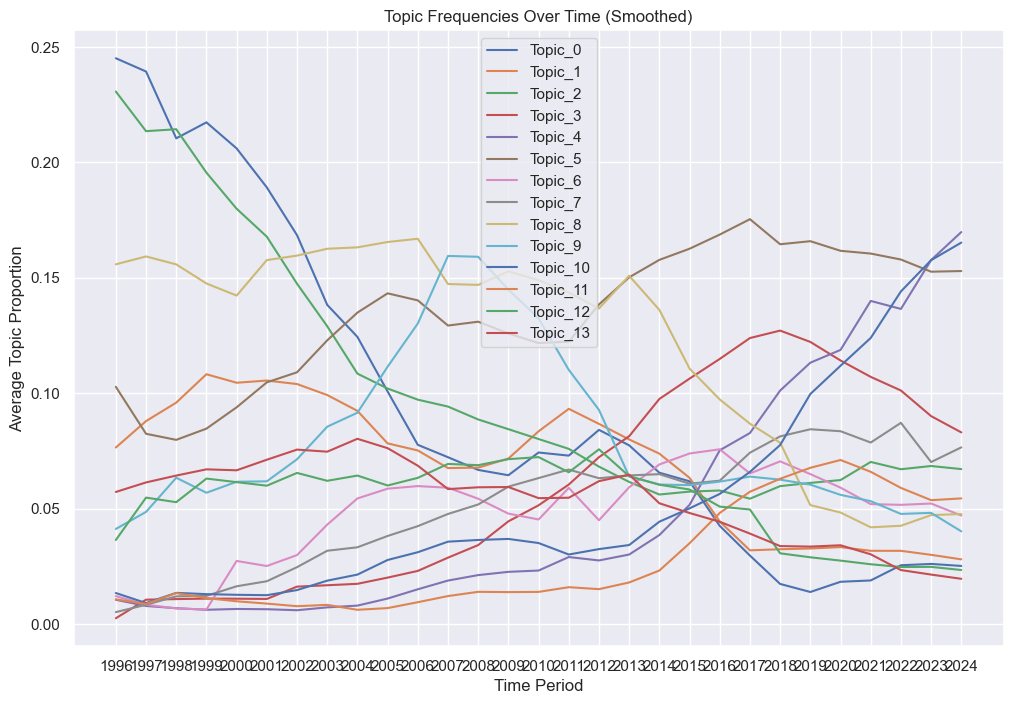

<Figure size 1400x1000 with 0 Axes>

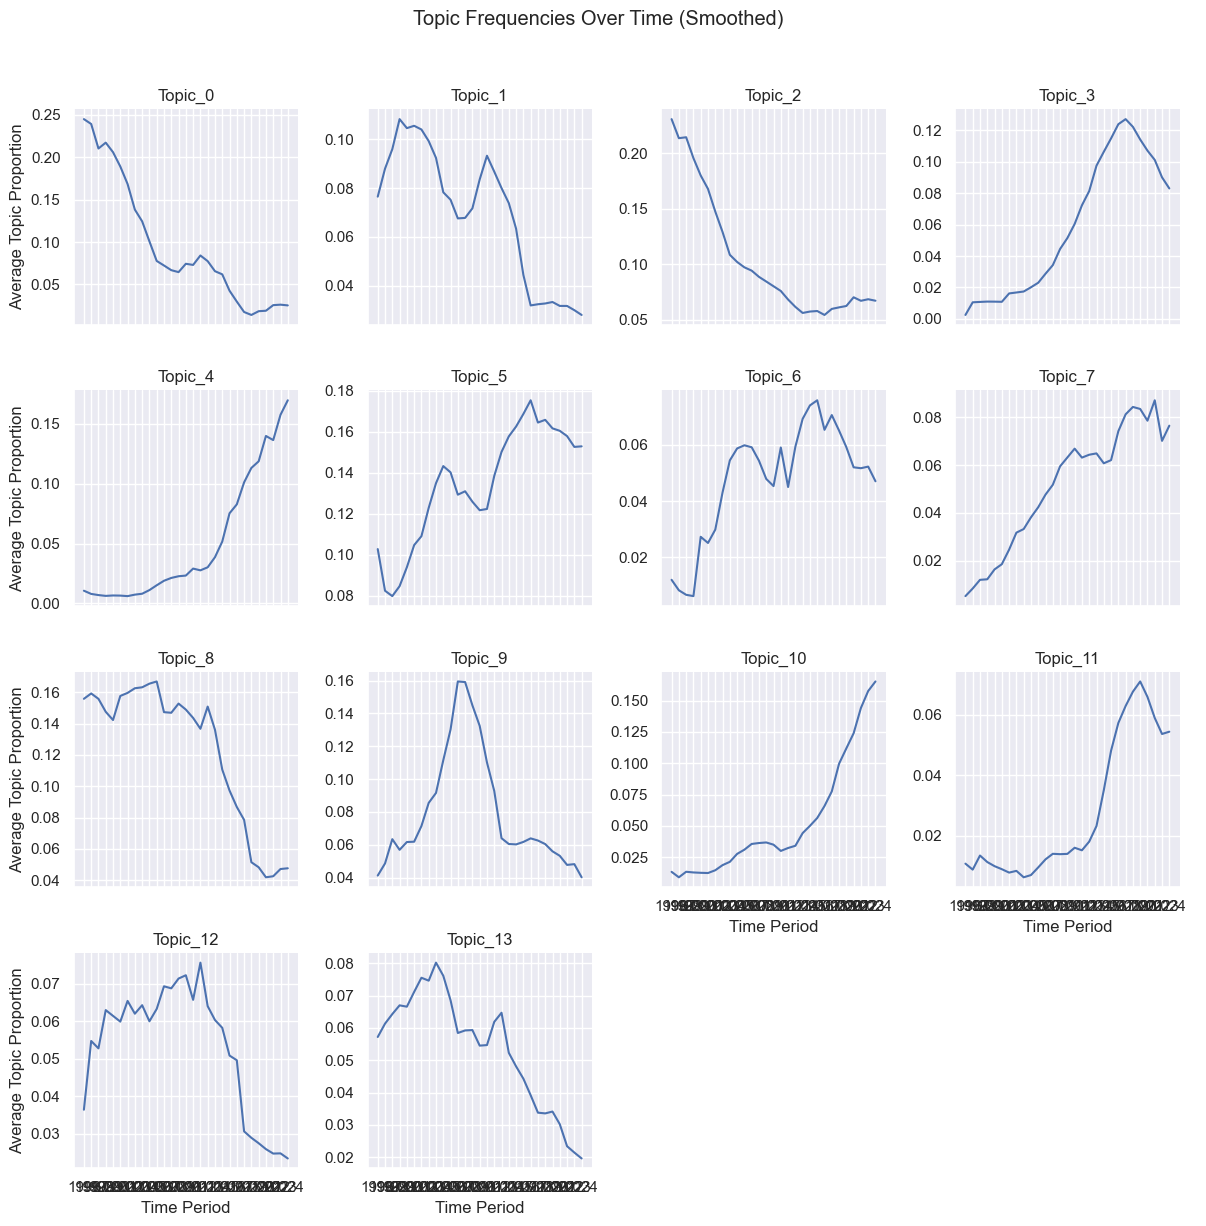

In [53]:
Graph_From_Model(file_paths, timestamps,  model)

In [22]:
def lda_make_long_csv(file_paths, timestamps, mdl, word_num=25):
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    texts.append(words)
                    doc_timestamps.append(timestamp)

    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    
    topics=[]
    fin_df = {'Topic':[], 'Type':[], 'Word':[], 'Score':[], 'Lambda':[]}
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        print(f'Topic #{k}')
        words_probs = mdl.get_topic_words(k, top_n=word_num)
        top_prob_words = [(word, prob) for word, prob in words_probs[:word_num]]

        relevance_scores = [relevance_lambda[k] for relevance_lambda in relevance]
        relevance_indices = [np.argsort(relevance_scores_lambda)[::-1] for relevance_scores_lambda in relevance_scores]
        saliency_scores = saliency[k]
        saliency_indices = np.argsort(saliency_scores)[::-1]

        top_relevance_words = [(vocab[idx], relevance_scores[i][idx]) for i, relevance_indice_lambdas in enumerate(relevance_indices) for idx in relevance_indice_lambdas[:word_num] ]
        top_saliency_words = [(vocab[idx], saliency_scores[idx]) for idx in saliency_indices[:word_num]]
        print(f"relevance {len(top_relevance_words)}")
        print(f"saliency {len(top_saliency_words)}")
        print(f"probability {len(top_prob_words)}")

        prob_words = [word for word, _ in top_prob_words]
        prob_values = [str(score) for _, score in top_prob_words]
        relevance_words = [word for word, _ in top_relevance_words ]
        relevance_values = [str(score) for _, score in top_relevance_words]
        saliency_words = [word for word, _ in top_saliency_words]
        saliency_values = [str(score) for _, score in top_saliency_words]
        
        # Create DataFrame with words and scores for all three metrics
        # combined_df = pd.DataFrame({
        #     'Probability Words': prob_words,
        #     'Relevance Words': relevance_words,
        #     'Saliency Words': saliency_words,
        #     'Probability Scores': prob_values,
        #     'Relevance Scores': relevance_values,
        #     'Saliency Scores': saliency_values
        # })

        Topics = [f'Topic {k}'] * 6* word_num
        fin_df['Topic'] += Topics
        Type = ['Probability'] * word_num + ['Relevance'] *word_num*4+ ['Saliency']*word_num
        fin_df['Type'] += Type
        # Words = [" ".join(prob_words), " ".join(relevance_words), " ".join(saliency_words)]
        fin_df['Word'] += (prob_words + relevance_words + saliency_words)
        #Scores = [" ".join(prob_values), " ".join(relevance_values),  " ".join(saliency_values)]
        fin_df['Score'] += (prob_values + relevance_values + saliency_values)
        #fin_df['Scores'] += Scores 0.,0.25, 0.5, 0.75
        fin_df['Lambda']+= ([None] * word_num + ["0."] * word_num + ["0.25"] * word_num + ["0.5"] * word_num + ["0.75"] * word_num + [None] * word_num)
        for val in fin_df:
            print(len(fin_df[val]))
    fin_df = pd.DataFrame(data=fin_df)
    fin_df.to_csv('results_all.csv')  

In [23]:
lda_make_long_csv(file_paths, timestamps,  model)

Topic #0
relevance 100
saliency 25
probability 25
150
150
150
150
150
Topic #1
relevance 100
saliency 25
probability 25
300
300
300
300
300
Topic #2
relevance 100
saliency 25
probability 25
450
450
450
450
450
Topic #3
relevance 100
saliency 25
probability 25
600
600
600
600
600
Topic #4
relevance 100
saliency 25
probability 25
750
750
750
750
750
Topic #5
relevance 100
saliency 25
probability 25
900
900
900
900
900
Topic #6
relevance 100
saliency 25
probability 25
1050
1050
1050
1050
1050
Topic #7
relevance 100
saliency 25
probability 25
1200
1200
1200
1200
1200
Topic #8
relevance 100
saliency 25
probability 25
1350
1350
1350
1350
1350
Topic #9
relevance 100
saliency 25
probability 25
1500
1500
1500
1500
1500
Topic #10
relevance 100
saliency 25
probability 25
1650
1650
1650
1650
1650
Topic #11
relevance 100
saliency 25
probability 25
1800
1800
1800
1800
1800
Topic #12
relevance 100
saliency 25
probability 25
1950
1950
1950
1950
1950
Topic #13
relevance 100
saliency 25
probability 25
2

# BertTopic


In [ ]:

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

main_directory_path = '/kaggle/input/psb-conference-papers/main_body/'

print('get files')

file_paths, timestamps = get_all_files_in_directory(main_directory_path)


In [ ]:
#embeddings_loaded = np.load('/kaggle/input/psb-conference-papers/embeddings.npy')

In [ ]:
'''import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
def bert_topic_analysis(file_paths, timestamps, batch_size=10000):
    texts = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            processed_text = preprocess_text(text)
            texts.append(processed_text)

    texts = [item for sublist in texts for item in sublist] if any(isinstance(i, list) for i in texts) else texts
    
    model = SentenceTransformer('all-MiniLM-L6-v2')

    #embeddings = model.encode(texts, show_progress_bar=True)
    #np.save('embeddings.npy', embeddings)
    embeddings = embeddings_loaded
    timestamps = pd.to_datetime(timestamps, errors='coerce')
    topic_model = BERTopic()
    topics, probs = topic_model.fit_transform(texts,embeddings)


    df = pd.DataFrame({"Text": texts, "Timestamp": timestamps, "Topic": topics})

    topic_over_time = df.groupby(['Timestamp', 'Topic']).size().unstack(fill_value=0)
    topic_over_time = topic_over_time.div(topic_over_time.sum(axis=1), axis=0)

    topic_over_time = topic_over_time.sort_index()

    topic_over_time_smooth = topic_over_time.rolling(window=3, min_periods=1).mean()

    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns:
        plt.plot(topic_over_time_smooth.index, topic_over_time_smooth[topic], label=f'Topic {topic}')
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()

    topics_over_time_df = topic_model.topics_over_time(texts, timestamps)

    fig = topic_model.visualize_topics_over_time(topics_over_time_df)
    fig.show()

    for topic in set(all_topics):
        print(f"Topic {topic}:")
        topic_words = topic_model.get_topic(topic)[:]
        first_words = [word for word, _ in topic_words]  # Extract the first element of each tuple
        print(first_words)
        print("\n")

main_directory_path = '/kaggle/input/psb-conference-papers/main_body/'

print('Running BERTopic')

file_paths, timestamps = get_all_files_in_directory(main_directory_path)

bert_topic_analysis(file_paths, timestamps, batch_size=100)
'''